<a href="https://colab.research.google.com/github/lmansf/Learning-Pytorch/blob/main/PyTorch_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version 2.9.0+cu126
Torchvision version 0.24.0+cu126
Numpy version 2.0.2
Pandas version 2.2.2


In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
dataset = PlayingCardDataset(
    data_dir='/content/drive/MyDrive/archive (7)/train'
)

In [ ]:
len(dataset)

7624

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/content/drive/MyDrive/archive (7)/train'
dataset = PlayingCardDataset(data_dir, transform)

In [ ]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
  break

In [ ]:
images.shape

torch.Size([32, 3, 128, 128])

In [ ]:
labels.shape

torch.Size([32])

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [ ]:
model = SimpleCardClassifer(num_classes=53)

In [ ]:
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [ ]:
model(images)

tensor([[-0.4996,  0.0967, -0.3908,  ...,  0.9548,  0.3382,  0.2003],
        [-0.3512, -0.1668,  0.0790,  ...,  0.1832,  0.1941,  0.2298],
        [-0.6684,  0.3332,  0.0912,  ..., -0.1501, -0.0155,  0.1731],
        ...,
        [ 0.3434,  0.2166, -0.0798,  ..., -0.0666, -0.0292, -0.2095],
        [-0.0543, -0.0727,  0.2833,  ...,  0.1786, -0.0329, -0.1155],
        [-0.2189,  0.3571,  0.4506,  ...,  0.3625,  0.1893,  0.1592]],
       grad_fn=<AddmmBackward0>)

In [ ]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/drive/MyDrive/archive (7)/train'
valid_folder = '/content/drive/MyDrive/archive (7)/valid'
test_folder = '/content/drive/MyDrive/archive (7)/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5698005483883501, Validation loss: 0.39716901419297707


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.563188198418332, Validation loss: 0.24692520420506314


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3373257789569286, Validation loss: 0.13520168538363475


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.24881421232836445, Validation loss: 0.14017466824009733


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.19438986658096188, Validation loss: 0.0773447462972605


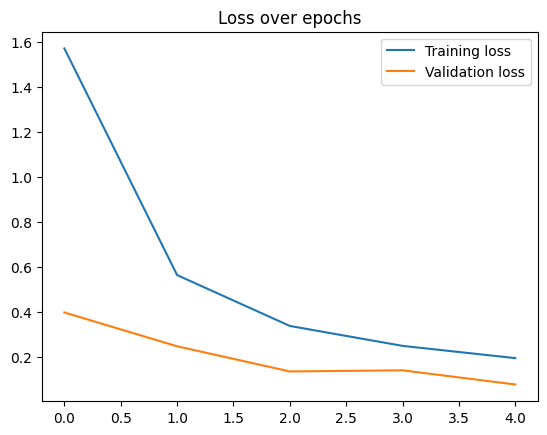

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

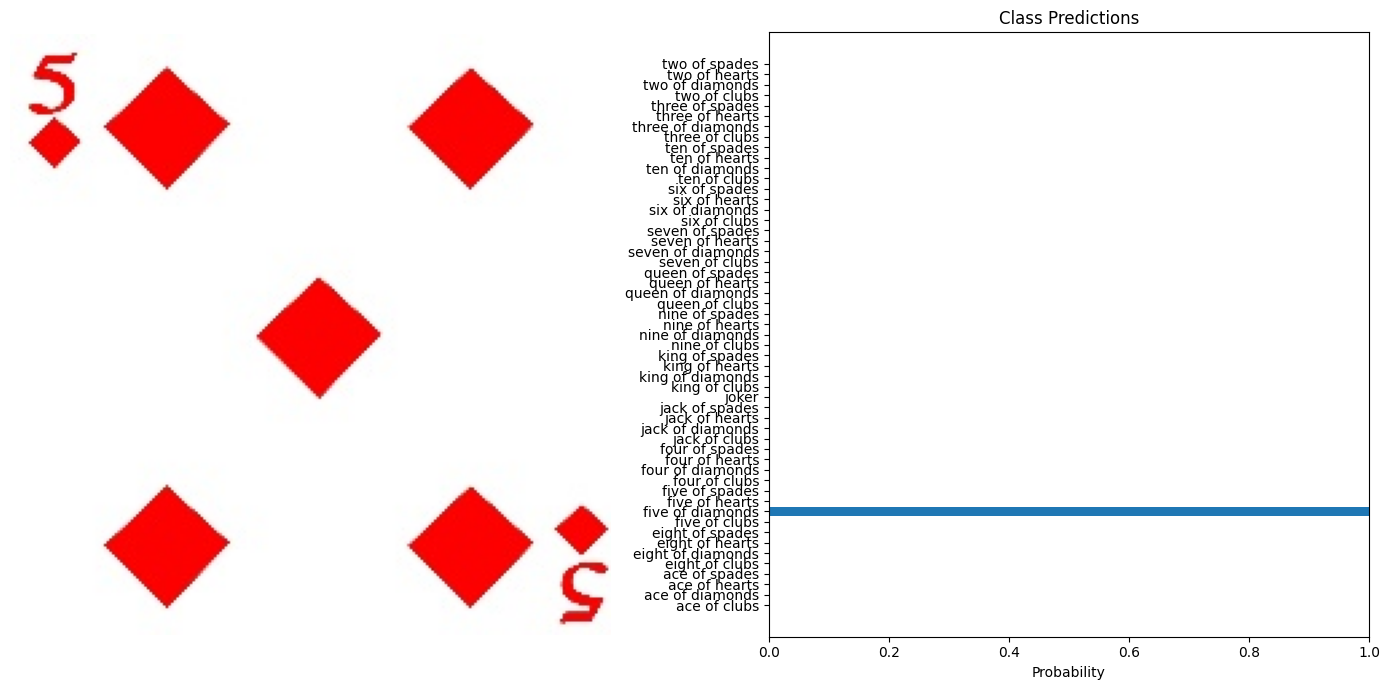

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/content/drive/MyDrive/archive (7)/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

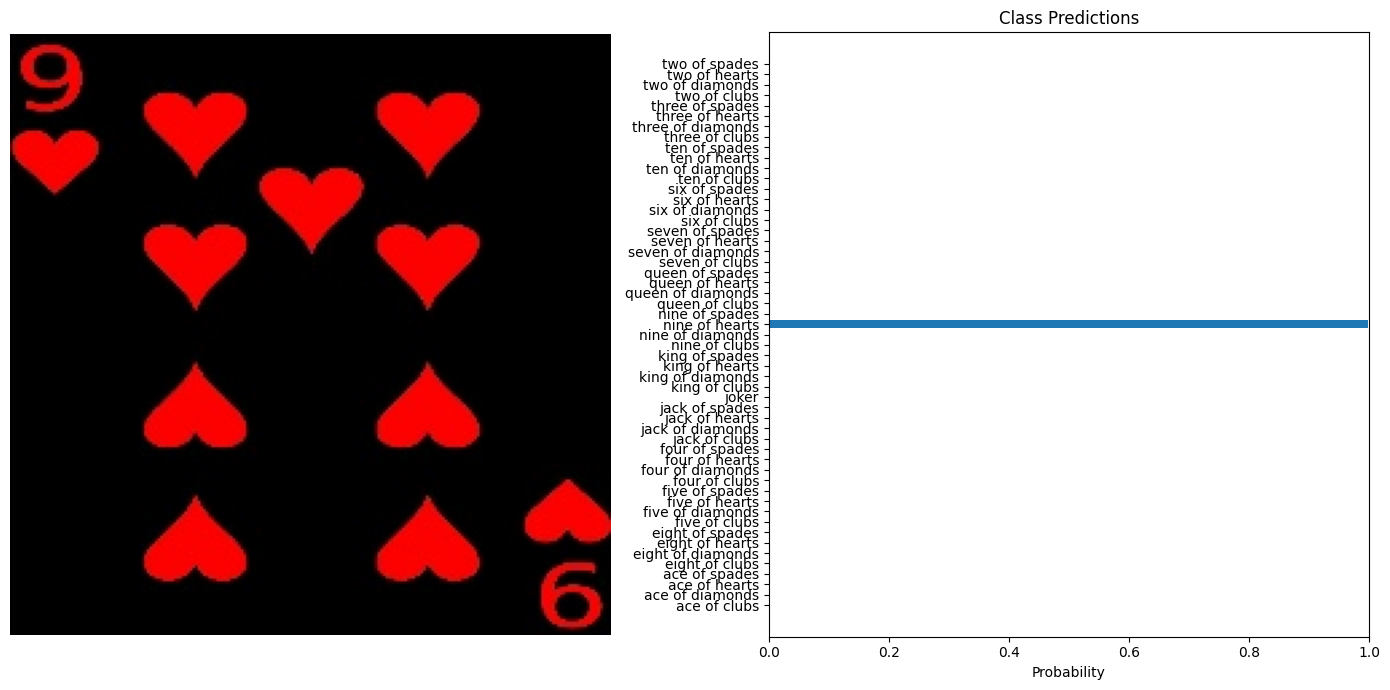

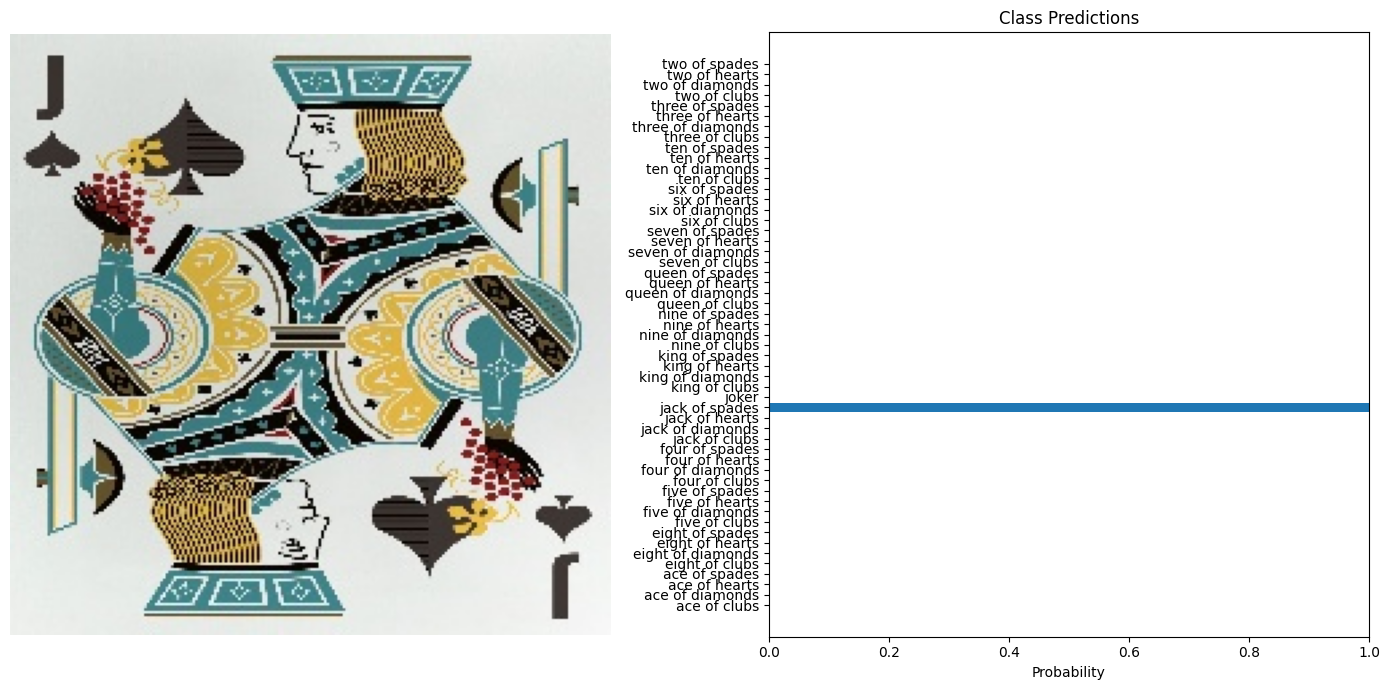

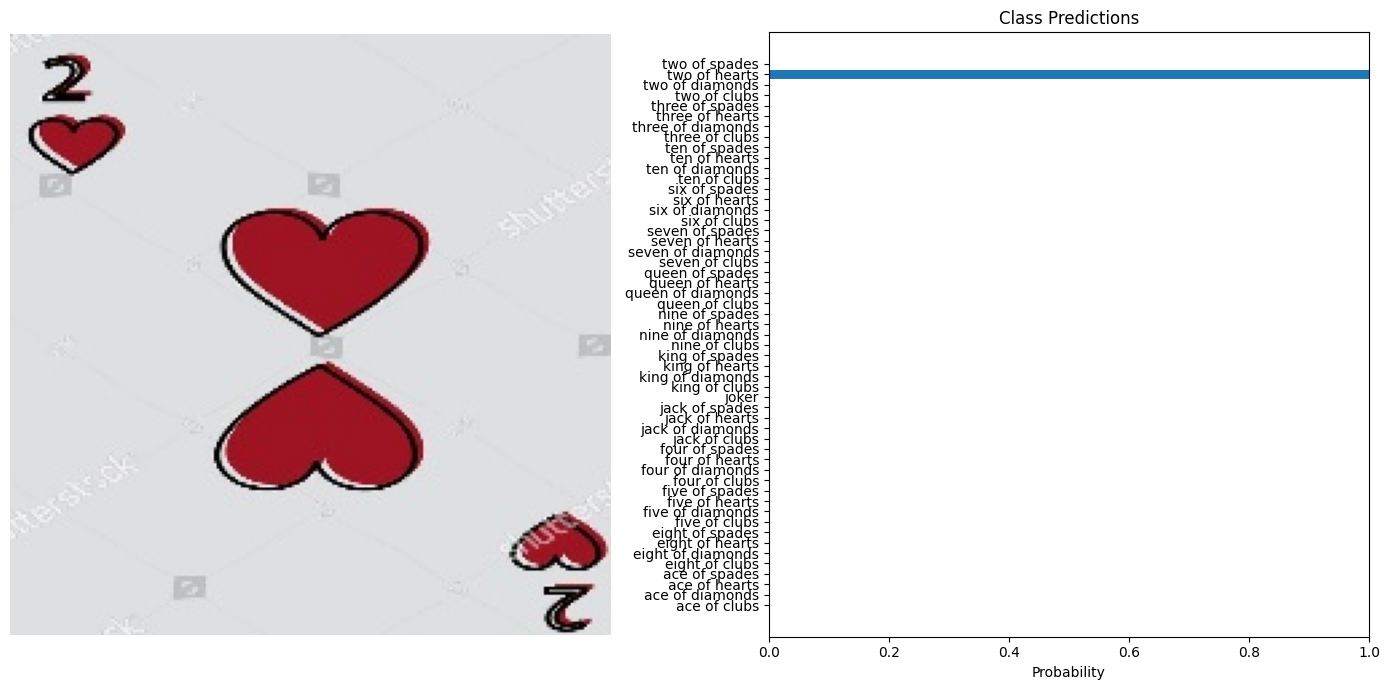

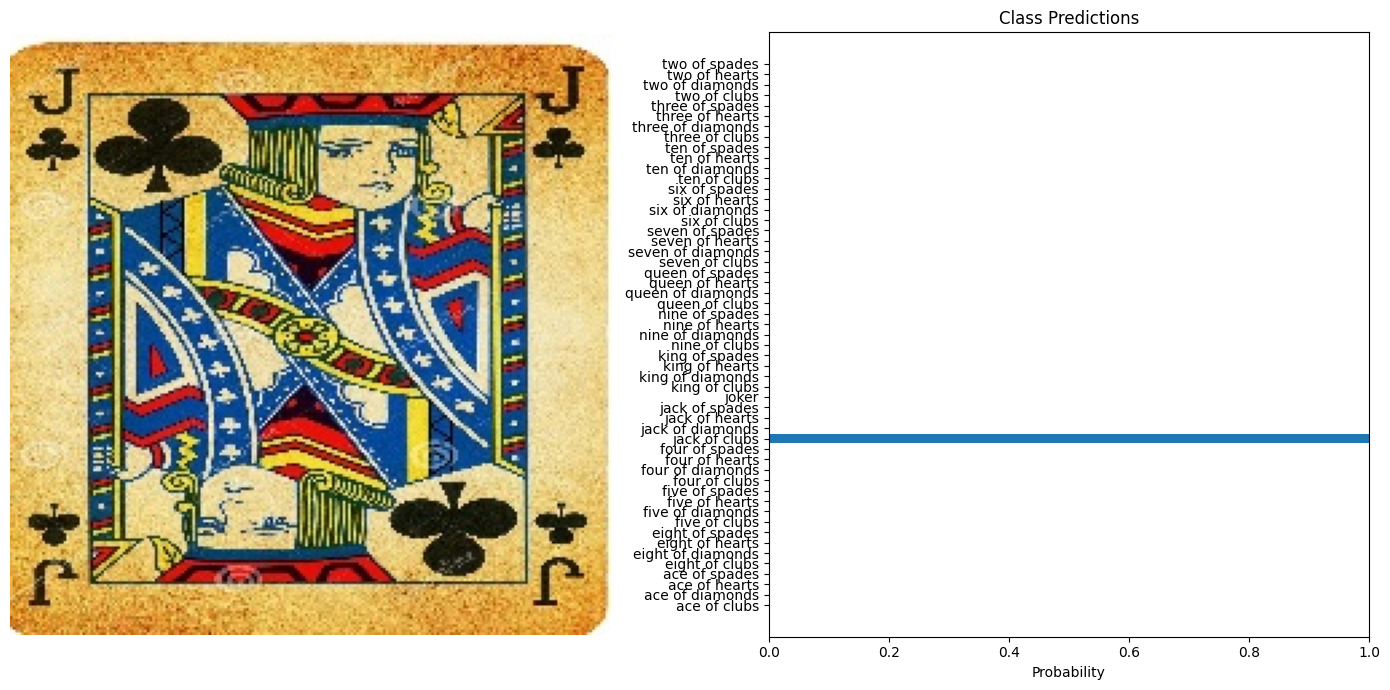

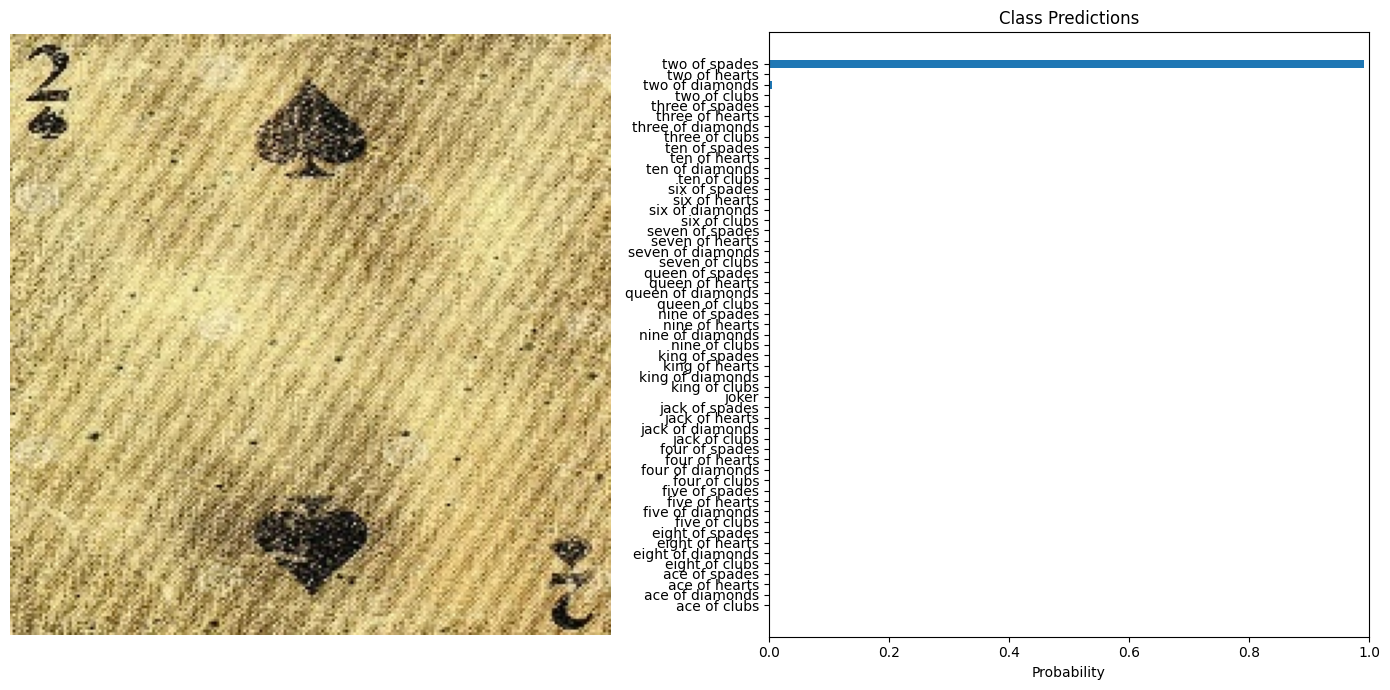

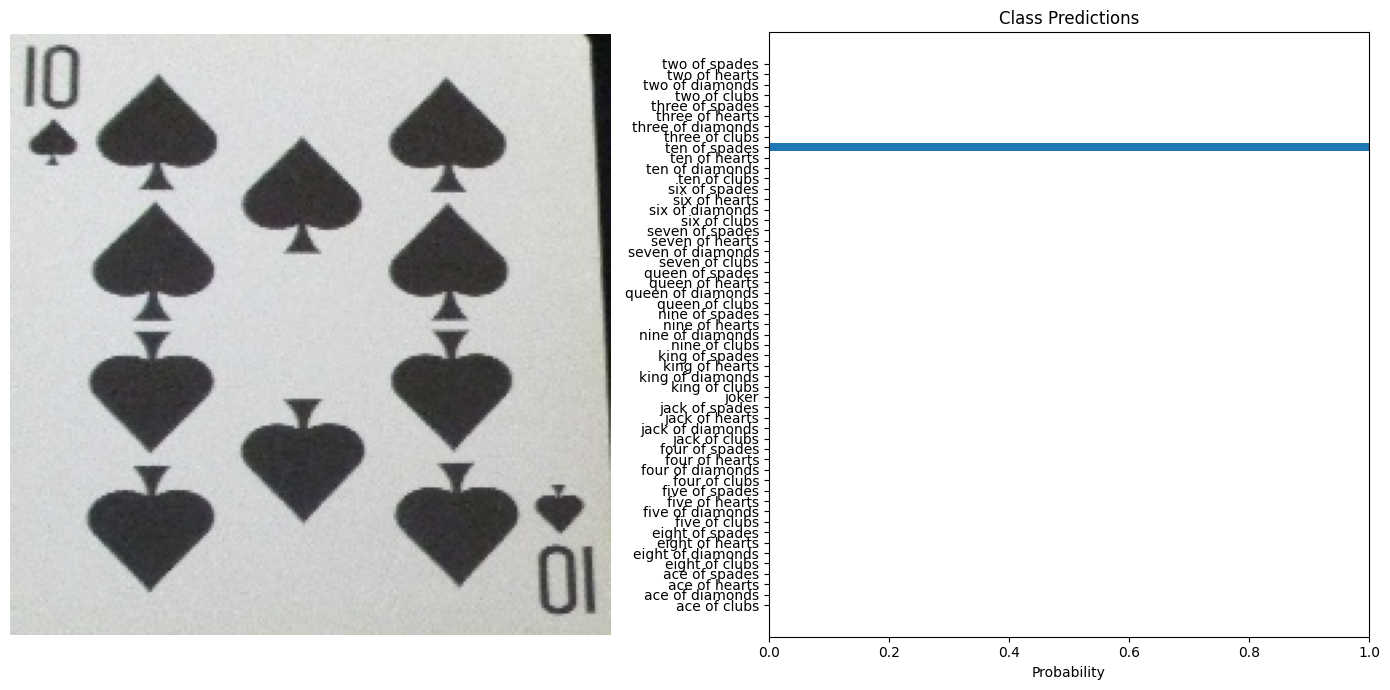

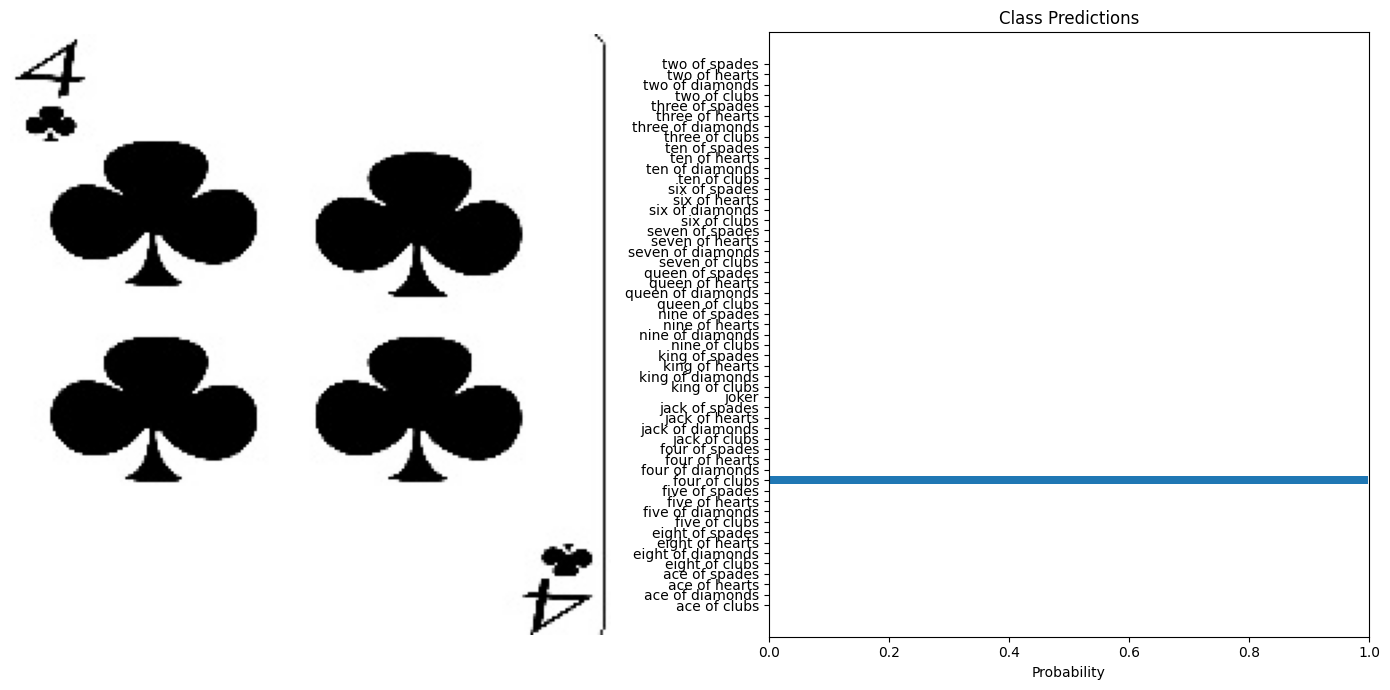

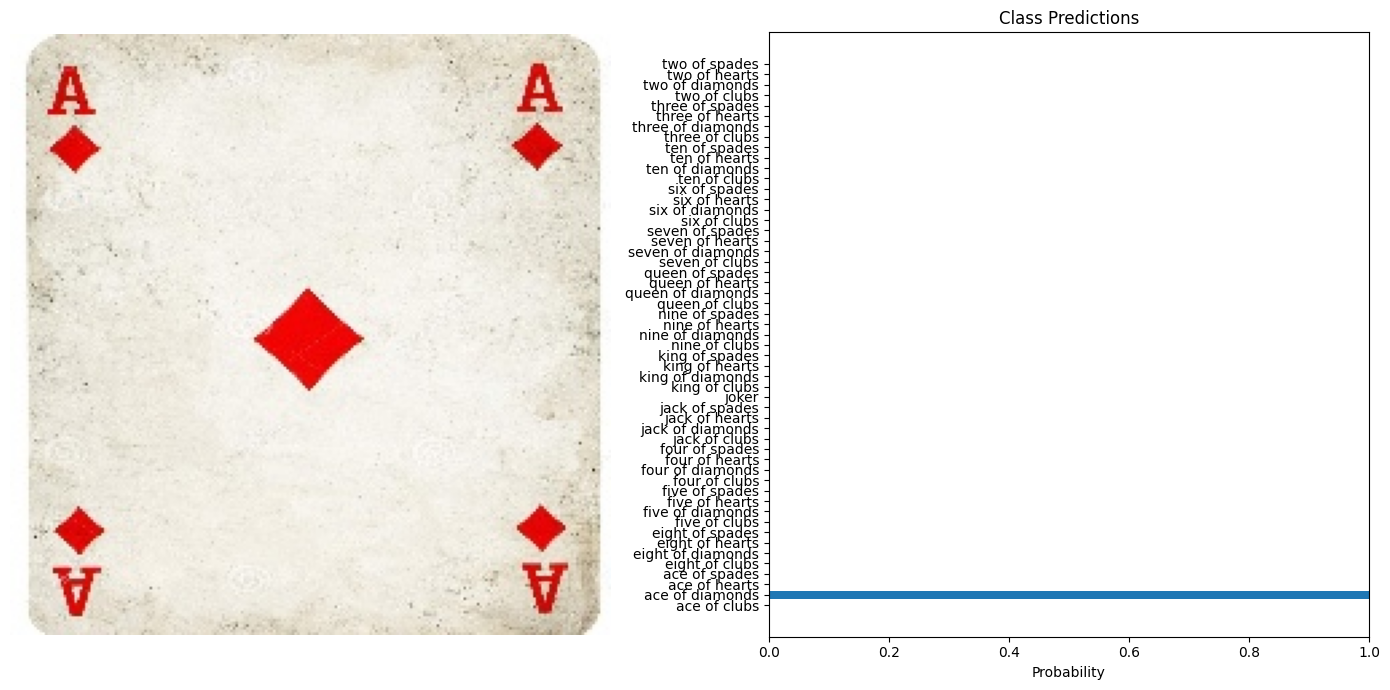

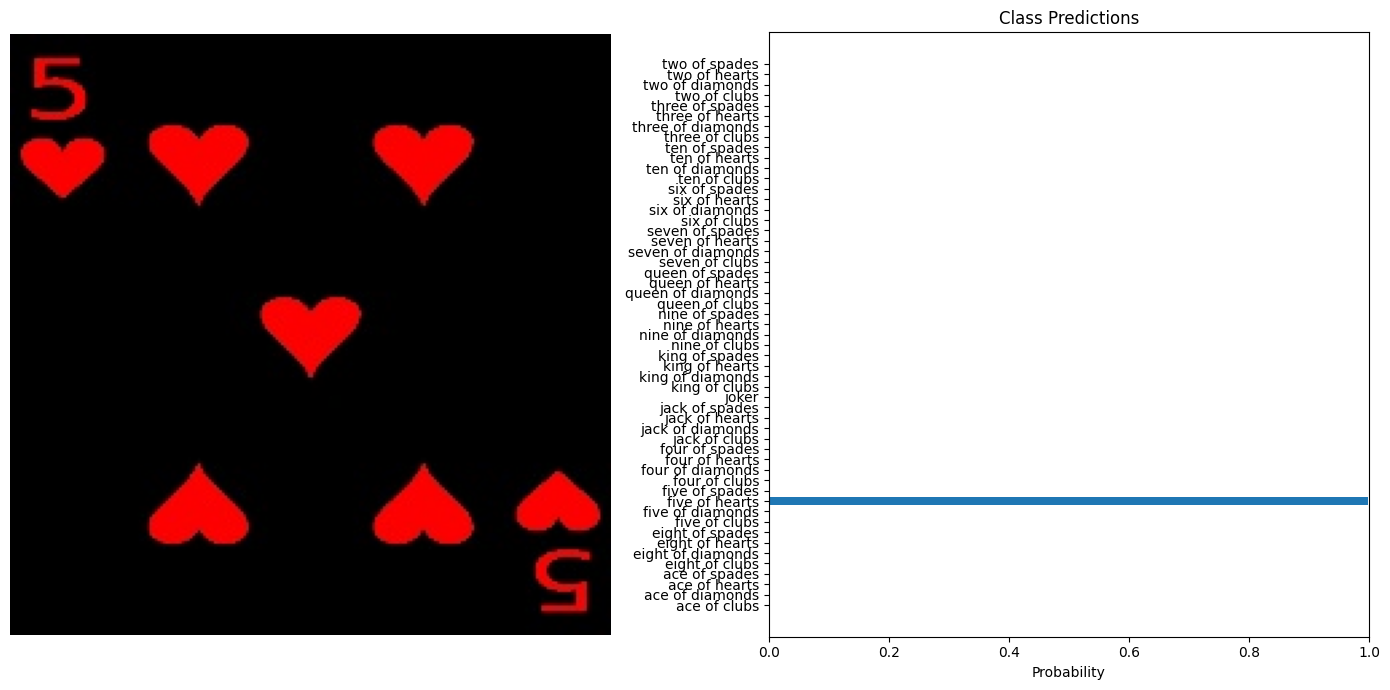

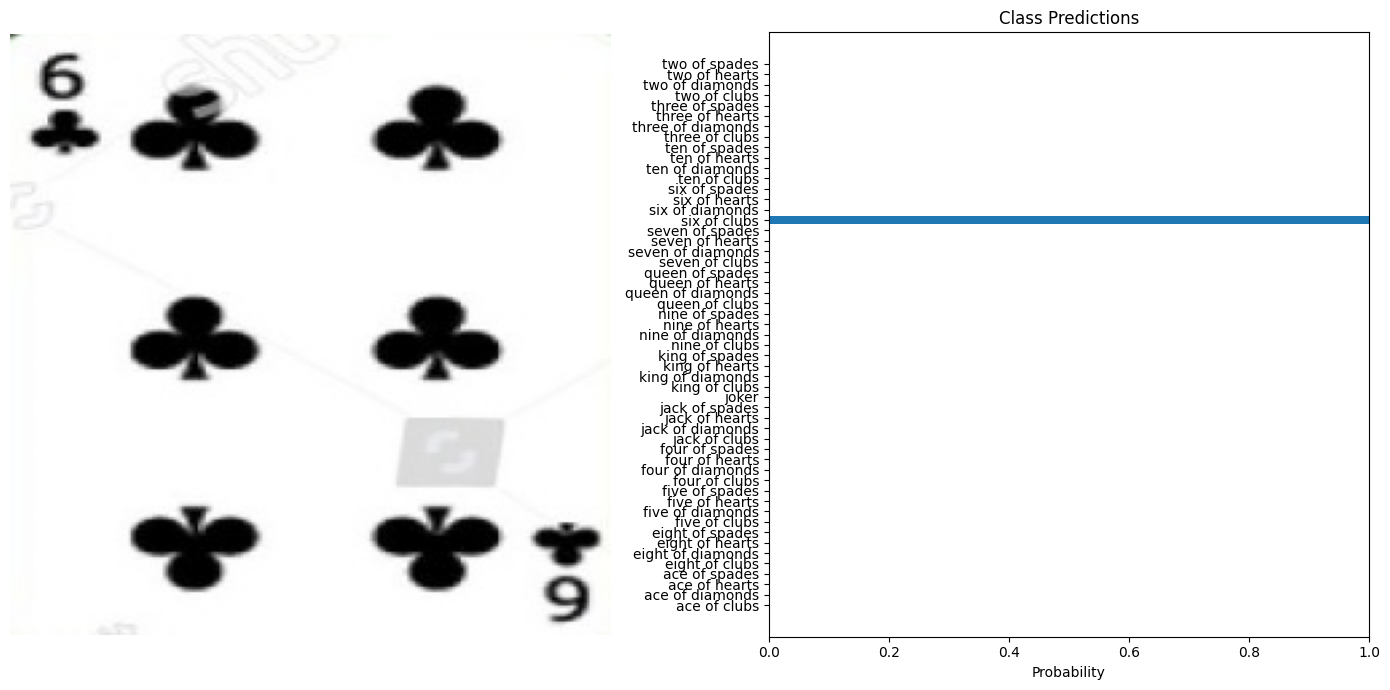

In [ ]:
from glob import glob
test_images = glob('/content/drive/MyDrive/archive (7)/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)